In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle
import json

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load dates from npy file 
dates = np.load('dates.npy', allow_pickle=True)
dates

array(['2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
       '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06',
       '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12',
       '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06',
       '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
       '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06',
       '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12',
       '2023-01', '2023-02', '2023-03', '2023-04', '2023-05'],
      dtype=object)

# PART 1 - realGDP Data

### This rGDP data in yearly, we simple broadcast it for all date-times of the 'NEXT' year

    Basically:
        2019-07 to 2019-12 has data: RGDP_2018 (imputed, we don't have county level data for 2018)
        2020-01 to 2020-12 has data: RGDP_2019
        2021-01 to 2021-12 has data: RGDP_2020
        2022-01 to 2022-12 has data: RGDP_2021
        2023-01 to 2023-05 has data: RGDP_2022 (imputed, we don't have county level data for 2022)

In [3]:
# rGDP data
dtypes = {'cfips': str}

rGDP_df = pd.read_csv('Scrapped_GDP_DATA/rGDP_19_20_21.csv', dtype=dtypes)
rGDP_df.head()

,cfips,RGDP_2019,RGDP_2020,RGDP_2021
0,01001,1543336.0,1525591.0,1502153.0
1,01003,7132205.0,7142139.0,7830237.0
2,01005,728447.0,699829.0,709459.0
3,01007,380403.0,398101.0,392249.0
4,01009,937239.0,883216.0,997835.0


### Making the assumping of geometric growth, we impute 2018 and 2022 as:

        rate = (RGDP_2021/RGDP_2019)**(1/2)
        RGDP_2018_imp = RGDP_2019 / rate
        RGDP_2022_imp = RGDP_2021 * rate

In [4]:
rGDP_df['rate'] = np.sqrt(rGDP_df['RGDP_2021']/rGDP_df['RGDP_2019'])
rGDP_df['RGDP_2018_imp'] = rGDP_df['RGDP_2019']/rGDP_df['rate']
rGDP_df['RGDP_2022_imp'] = rGDP_df['RGDP_2021']*rGDP_df['rate']
rGDP_df.head()

,cfips,RGDP_2019,RGDP_2020,RGDP_2021,rate,RGDP_2018_imp,RGDP_2022_imp
0,01001,1543336.0,1525591.0,1502153.0,0.986568,1.564349e+06,1.481975e+06
1,01003,7132205.0,7142139.0,7830237.0,1.047793,6.806883e+06,8.204469e+06
2,01005,728447.0,699829.0,709459.0,0.986881,7.381307e+05,7.001514e+05
3,01007,380403.0,398101.0,392249.0,1.015451,3.746148e+05,3.983096e+05
4,01009,937239.0,883216.0,997835.0,1.031821,9.083352e+05,1.029587e+06


In [5]:
rGDP_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cfips          3142 non-null   object 
 1   RGDP_2019      3089 non-null   float64
 2   RGDP_2020      3089 non-null   float64
 3   RGDP_2021      3089 non-null   float64
 4   rate           3088 non-null   float64
 5   RGDP_2018_imp  3088 non-null   float64
 6   RGDP_2022_imp  3088 non-null   float64
dtypes: float64(6), object(1)
memory usage: 172.0+ KB


In [6]:
# show the counties with missing data
missing_list = rGDP_df[rGDP_df['rate'].isna()]['cfips'].to_numpy()
missing_list

array(['02261', '15005', '15009', '51003', '51005', '51015', '51031',
       '51035', '51053', '51059', '51069', '51081', '51089', '51095',
       '51121', '51143', '51149', '51153', '51161', '51163', '51165',
       '51175', '51177', '51191', '51195', '51199', '51520', '51530',
       '51540', '51570', '51580', '51590', '51595', '51600', '51610',
       '51620', '51630', '51640', '51660', '51670', '51678', '51680',
       '51683', '51685', '51690', '51720', '51730', '51735', '51750',
       '51775', '51790', '51820', '51830', '51840'], dtype=object)

In [7]:
# load cfips to county name mapping csv
dtypes = {'cfips': str}
cfips_to_county = pd.read_csv('cfips_to_county_name.csv', dtype=dtypes)
cfips_to_county.head()

,cfips,county_name,state
0,01001,Autauga County,AL
1,01003,Baldwin County,AL
2,01005,Barbour County,AL
3,01007,Bibb County,AL
4,01009,Blount County,AL


In [8]:
# find santa barbara county
cfips_to_county[cfips_to_county['cfips']=='06083']

,cfips,county_name,state
227,06083,Santa Barbara County,CA


### Imputation with bootstraped same state sample counties

In [9]:
# impute missing data
for cfips in missing_list:
    closest_cfips = cfips_to_county[cfips_to_county['cfips'].str.startswith(cfips[:2])]['cfips'].to_numpy()
    closest_cfips = closest_cfips[closest_cfips != cfips]
    # find those no in missing list
    closest_cfips = closest_cfips[~np.isin(closest_cfips, missing_list)]
    # sample 10 times with replacement
    closest_cfips = np.random.choice(closest_cfips, 10, replace=True)
    imputed_data = rGDP_df[rGDP_df['cfips'].isin(closest_cfips)].mean()
    # fill in the missing data for the role of that cfips except for cfips
    rGDP_df.loc[rGDP_df['cfips'] == cfips, 'RGDP_2019'] = imputed_data['RGDP_2019']
    rGDP_df.loc[rGDP_df['cfips'] == cfips, 'RGDP_2020'] = imputed_data['RGDP_2020']
    rGDP_df.loc[rGDP_df['cfips'] == cfips, 'RGDP_2021'] = imputed_data['RGDP_2021']
    rGDP_df.loc[rGDP_df['cfips'] == cfips, 'RGDP_2018_imp'] = imputed_data['RGDP_2018_imp']
    rGDP_df.loc[rGDP_df['cfips'] == cfips, 'RGDP_2022_imp'] = imputed_data['RGDP_2022_imp']
    rGDP_df.loc[rGDP_df['cfips'] == cfips, 'rate'] = imputed_data['rate']

rGDP_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cfips          3142 non-null   object 
 1   RGDP_2019      3142 non-null   float64
 2   RGDP_2020      3142 non-null   float64
 3   RGDP_2021      3142 non-null   float64
 4   rate           3142 non-null   float64
 5   RGDP_2018_imp  3142 non-null   float64
 6   RGDP_2022_imp  3142 non-null   float64
dtypes: float64(6), object(1)
memory usage: 172.0+ KB


In [10]:
rGDP_df.head()

,cfips,RGDP_2019,RGDP_2020,RGDP_2021,rate,RGDP_2018_imp,RGDP_2022_imp
0,01001,1543336.0,1525591.0,1502153.0,0.986568,1.564349e+06,1.481975e+06
1,01003,7132205.0,7142139.0,7830237.0,1.047793,6.806883e+06,8.204469e+06
2,01005,728447.0,699829.0,709459.0,0.986881,7.381307e+05,7.001514e+05
3,01007,380403.0,398101.0,392249.0,1.015451,3.746148e+05,3.983096e+05
4,01009,937239.0,883216.0,997835.0,1.031821,9.083352e+05,1.029587e+06


In [11]:
# get rid off the rate column
rGDP_df = rGDP_df.drop(columns=['rate'])
rGDP_df.head()

,cfips,RGDP_2019,RGDP_2020,RGDP_2021,RGDP_2018_imp,RGDP_2022_imp
0,01001,1543336.0,1525591.0,1502153.0,1.564349e+06,1.481975e+06
1,01003,7132205.0,7142139.0,7830237.0,6.806883e+06,8.204469e+06
2,01005,728447.0,699829.0,709459.0,7.381307e+05,7.001514e+05
3,01007,380403.0,398101.0,392249.0,3.746148e+05,3.983096e+05
4,01009,937239.0,883216.0,997835.0,9.083352e+05,1.029587e+06


In [12]:
# reorganize the columns
rGDP_df = rGDP_df[['cfips', 'RGDP_2018_imp', 'RGDP_2019', 'RGDP_2020', 'RGDP_2021', 'RGDP_2022_imp']]

## Make the 3D block

In [13]:
dates

array(['2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
       '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06',
       '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12',
       '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06',
       '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
       '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06',
       '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12',
       '2023-01', '2023-02', '2023-03', '2023-04', '2023-05'],
      dtype=object)

In [14]:
dates_in_2019 = [date for date in dates if date[:4] == '2019']
dates_in_2020 = [date for date in dates if date[:4] == '2020']
dates_in_2021 = [date for date in dates if date[:4] == '2021']
dates_in_2022 = [date for date in dates if date[:4] == '2022']
dates_in_2023 = [date for date in dates if date[:4] == '2023']

### for each year:

    shape = (N_MONTH_IN_THE_YEAR, 1, 3142)

    since we have 1 feature:
        previous year's real GDP

In [15]:
dates_in_2019

['2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12']

In [16]:
n_month_2019 = len(dates_in_2019)
block_2019_one_slice = rGDP_df['RGDP_2018_imp'].to_numpy()
# broadcast to n_month_2019
block_2019_one_slice = np.repeat(block_2019_one_slice, n_month_2019)
block_2019_one_slice = block_2019_one_slice.reshape(-1, n_month_2019)
# add one more dimension
block_2019_one_slice = block_2019_one_slice[:, :, np.newaxis]
# sawp axis to shape (N_month, 1, N_county)
block_2019_one_slice = np.swapaxes(block_2019_one_slice, 0, 2)
block_2019_one_slice = np.swapaxes(block_2019_one_slice, 0, 1)
block_2019_one_slice.shape

(6, 1, 3142)

In [17]:
# data should match up with Autauga, Alabama's 
# RGDP_2018_imp == 1.564349e+06
# repeat 6 times
block_2019_one_slice[:,:,0]

array([[1564348.98710663],
       [1564348.98710663],
       [1564348.98710663],
       [1564348.98710663],
       [1564348.98710663],
       [1564348.98710663]])

In [18]:
# for 2020
n_month_2020 = len(dates_in_2020)
block_2020_one_slice = rGDP_df['RGDP_2019'].to_numpy()
# broadcast to n_month_2020
block_2020_one_slice = np.repeat(block_2020_one_slice, n_month_2020)
block_2020_one_slice = block_2020_one_slice.reshape(-1, n_month_2020)
# add one more dimension
block_2020_one_slice = block_2020_one_slice[:, :, np.newaxis]
# sawp axis to shape (N_month, 1, N_county)
block_2020_one_slice = np.swapaxes(block_2020_one_slice, 0, 2)
block_2020_one_slice = np.swapaxes(block_2020_one_slice, 0, 1)
block_2020_one_slice.shape

(12, 1, 3142)

In [19]:
# for 2021
n_month_2021 = len(dates_in_2021)
block_2021_one_slice = rGDP_df['RGDP_2020'].to_numpy()
# broadcast to n_month_2021
block_2021_one_slice = np.repeat(block_2021_one_slice, n_month_2021)
block_2021_one_slice = block_2021_one_slice.reshape(-1, n_month_2021)
# add one more dimension
block_2021_one_slice = block_2021_one_slice[:, :, np.newaxis]
# sawp axis to shape (N_month, 1, N_county)
block_2021_one_slice = np.swapaxes(block_2021_one_slice, 0, 2)
block_2021_one_slice = np.swapaxes(block_2021_one_slice, 0, 1)
block_2021_one_slice.shape

(12, 1, 3142)

In [20]:
# for 2022
n_month_2022 = len(dates_in_2022)
block_2022_one_slice = rGDP_df['RGDP_2021'].to_numpy()
# broadcast to n_month_2022
block_2022_one_slice = np.repeat(block_2022_one_slice, n_month_2022)
block_2022_one_slice = block_2022_one_slice.reshape(-1, n_month_2022)
# add one more dimension
block_2022_one_slice = block_2022_one_slice[:, :, np.newaxis]
# sawp axis to shape (N_month, 1, N_county)
block_2022_one_slice = np.swapaxes(block_2022_one_slice, 0, 2)
block_2022_one_slice = np.swapaxes(block_2022_one_slice, 0, 1)
block_2022_one_slice.shape

(12, 1, 3142)

In [21]:
# for 2023
n_month_2023 = len(dates_in_2023)
block_2023_one_slice = rGDP_df['RGDP_2022_imp'].to_numpy()
# broadcast to n_month_2023
block_2023_one_slice = np.repeat(block_2023_one_slice, n_month_2023)
block_2023_one_slice = block_2023_one_slice.reshape(-1, n_month_2023)
# add one more dimension
block_2023_one_slice = block_2023_one_slice[:, :, np.newaxis]
# sawp axis to shape (N_month, 1, N_county)
block_2023_one_slice = np.swapaxes(block_2023_one_slice, 0, 2)
block_2023_one_slice = np.swapaxes(block_2023_one_slice, 0, 1)
block_2023_one_slice.shape

(5, 1, 3142)

In [22]:
# concatenate all blocks on axis 0
block_2019_2023 = np.concatenate((  block_2019_one_slice, 
                                    block_2020_one_slice, 
                                    block_2021_one_slice, 
                                    block_2022_one_slice, 
                                    block_2023_one_slice), axis=0)

block_2019_2023.shape

(47, 1, 3142)

In [23]:
# show the rgdp data for Autauga, Alabama from rGDP_df,  cfips = 01001
rGDP_df[rGDP_df['cfips'] == '01001']

,cfips,RGDP_2018_imp,RGDP_2019,RGDP_2020,RGDP_2021,RGDP_2022_imp
0,01001,1.564349e+06,1543336.0,1525591.0,1502153.0,1.481975e+06


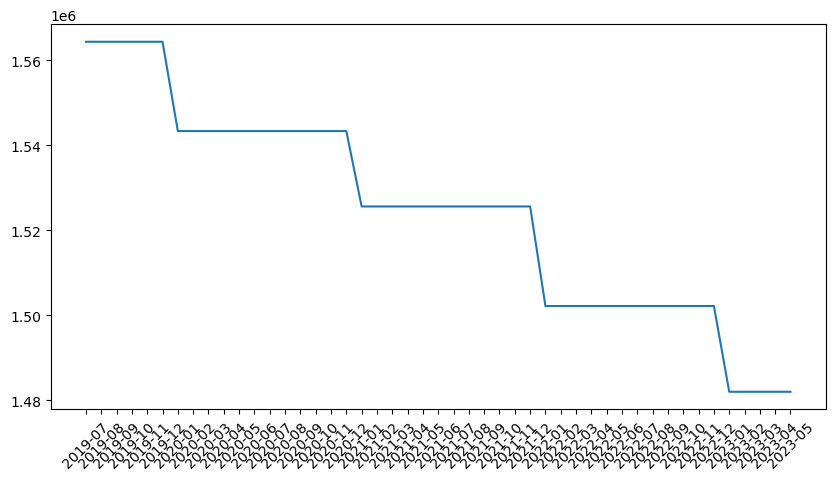

In [24]:
# slice for Autauga, Alabama, plot vs dates 
plt.figure(figsize=(10, 5))
plt.plot(dates, block_2019_2023[:,:,0])
plt.xticks(rotation=45)
plt.show()

### Autauga seem correct

In [25]:
# show the rgdp data for santa barbara, california from rGDP_df, cfips = 06083
rGDP_df[rGDP_df['cfips'] == '06083']

,cfips,RGDP_2018_imp,RGDP_2019,RGDP_2020,RGDP_2021,RGDP_2022_imp
227,06083,2.636682e+07,27069375.0,27085759.0,28531154.0,2.929138e+07


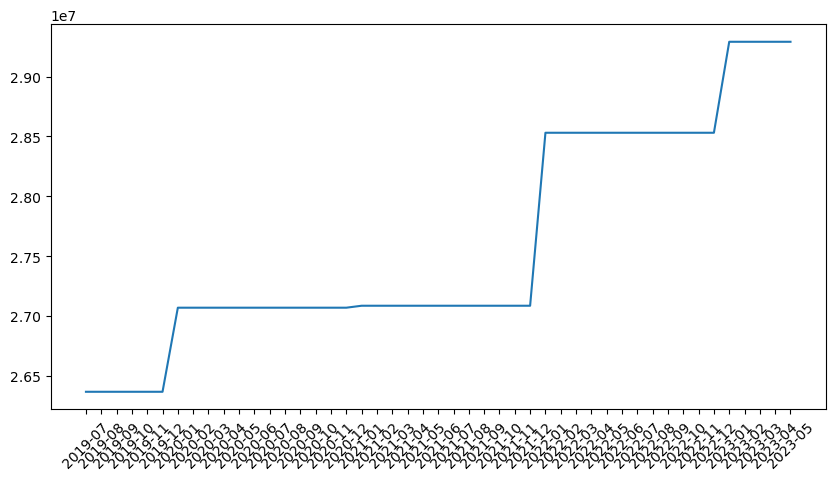

In [26]:
# slice for Santa Barbara, plot vs dates 
plt.figure(figsize=(10, 5))
plt.plot(dates, block_2019_2023[:,:,227])
plt.xticks(rotation=45)
plt.show()

### Santa Barbara seems correct

In [27]:
block_2019_2023.shape

(47, 1, 3142)

In [28]:
data_name = 'PrevYr_RGDP'
data_description = {'feature_0': 'PrevYr_RGDP'}

# save the block_2019_2023 to pickle file
with open(f'BLOCKED_{data_name}_data.pkl', 'wb') as f:
    pickle.dump(block_2019_2023, f)

# save the data description in json format
with open(f'BLOCKED_{data_name}_data_description.json', 'w') as f:
    json.dump(data_description, f)

# PART 2 - Sector GDP Data

In [29]:
# sectorGDP data
dtypes = {'cfips': str}

sectorGDP_df = pd.read_csv('Scrapped_GDP_DATA/sectorGDPpct_19_20_21.csv', dtype=dtypes)
sectorGDP_df.head()

,cfips,GDP_Agri_pct_2019,GDP_Agri_pct_2020,GDP_Agri_pct_2021,GDP_Mine_pct_2019,GDP_Mine_pct_2020,GDP_Mine_pct_2021,GDP_Retl_pct_2019,GDP_Retl_pct_2020,GDP_Retl_pct_2021,...,GDP_Gvmt_pct_2021,GDP_GoMn_pct_2019,GDP_GoMn_pct_2020,GDP_GoMn_pct_2021,GDP_GoTr_pct_2019,GDP_GoTr_pct_2020,GDP_GoTr_pct_2021,GDP_GoMf_pct_2019,GDP_GoMf_pct_2020,GDP_GoMf_pct_2021
0,01001,2.38,2.64,1.59,1.04,1.16,1.20,6.44,6.59,6.77,...,10.92,3.43,3.82,2.81,21.88,23.69,21.98,17.74,17.13,17.92
1,01003,0.33,0.55,0.43,0.19,0.18,0.18,12.42,12.17,11.39,...,9.76,0.52,0.78,0.63,2.15,2.29,2.10,8.86,7.78,7.93
2,01005,9.40,5.69,9.57,4.78,3.58,3.22,7.85,7.70,7.44,...,14.65,14.28,9.47,12.77,5.56,5.66,-0.00,26.88,28.97,26.63
3,01007,1.24,1.20,0.97,0.31,0.34,0.32,7.35,7.21,7.37,...,20.84,1.57,1.55,1.28,3.01,5.17,4.96,-0.00,-0.00,-0.00
4,01009,8.56,1.58,10.67,0.19,0.24,0.12,7.41,7.84,6.96,...,13.89,9.17,1.99,11.43,-0.00,-0.00,-0.00,13.94,13.93,13.36


In [30]:
# check for missing values
sectorGDP_df.isna().sum()

cfips                 0
GDP_Agri_pct_2019    53
GDP_Agri_pct_2020    53
GDP_Agri_pct_2021    53
GDP_Mine_pct_2019    53
GDP_Mine_pct_2020    53
GDP_Mine_pct_2021    53
GDP_Retl_pct_2019    53
GDP_Retl_pct_2020    53
GDP_Retl_pct_2021    53
GDP_Manu_pct_2019    53
GDP_Manu_pct_2020    53
GDP_Manu_pct_2021    53
GDP_Info_pct_2019    53
GDP_Info_pct_2020    53
GDP_Info_pct_2021    53
GDP_FinS_pct_2019    53
GDP_FinS_pct_2020    53
GDP_FinS_pct_2021    53
GDP_EduS_pct_2019    53
GDP_EduS_pct_2020    53
GDP_EduS_pct_2021    53
GDP_EntS_pct_2019    53
GDP_EntS_pct_2020    53
GDP_EntS_pct_2021    53
GDP_Gvmt_pct_2019    53
GDP_Gvmt_pct_2020    53
GDP_Gvmt_pct_2021    53
GDP_GoMn_pct_2019    53
GDP_GoMn_pct_2020    53
GDP_GoMn_pct_2021    53
GDP_GoTr_pct_2019    53
GDP_GoTr_pct_2020    53
GDP_GoTr_pct_2021    53
GDP_GoMf_pct_2019    53
GDP_GoMf_pct_2020    53
GDP_GoMf_pct_2021    53
dtype: int64

In [31]:
# show the counties with missing data
missing_list = sectorGDP_df[sectorGDP_df['GDP_Agri_pct_2019'].isna()]['cfips'].to_list()
missing_list

['15005',
 '15009',
 '51003',
 '51005',
 '51015',
 '51031',
 '51035',
 '51053',
 '51059',
 '51069',
 '51081',
 '51089',
 '51095',
 '51121',
 '51143',
 '51149',
 '51153',
 '51161',
 '51163',
 '51165',
 '51175',
 '51177',
 '51191',
 '51195',
 '51199',
 '51520',
 '51530',
 '51540',
 '51570',
 '51580',
 '51590',
 '51595',
 '51600',
 '51610',
 '51620',
 '51630',
 '51640',
 '51660',
 '51670',
 '51678',
 '51680',
 '51683',
 '51685',
 '51690',
 '51720',
 '51730',
 '51735',
 '51750',
 '51775',
 '51790',
 '51820',
 '51830',
 '51840']

In [32]:
# impute missing data
for cfips in missing_list:
    closest_cfips = cfips_to_county[cfips_to_county['cfips'].str.startswith(cfips[:2])]['cfips'].to_numpy()
    closest_cfips = closest_cfips[closest_cfips != cfips]
    # find those no in missing list
    closest_cfips = closest_cfips[~np.isin(closest_cfips, missing_list)]
    # sample 10 times with replacement
    closest_cfips = np.random.choice(closest_cfips, 10, replace=True)
    imputed_data = sectorGDP_df[sectorGDP_df['cfips'].isin(closest_cfips)].mean()
    for col in imputed_data.index[1:]:
        sectorGDP_df.loc[sectorGDP_df['cfips'] == cfips, col] = imputed_data[col]

In [33]:
# check for missing values
sectorGDP_df.isna().sum()

cfips                0
GDP_Agri_pct_2019    0
GDP_Agri_pct_2020    0
GDP_Agri_pct_2021    0
GDP_Mine_pct_2019    0
GDP_Mine_pct_2020    0
GDP_Mine_pct_2021    0
GDP_Retl_pct_2019    0
GDP_Retl_pct_2020    0
GDP_Retl_pct_2021    0
GDP_Manu_pct_2019    0
GDP_Manu_pct_2020    0
GDP_Manu_pct_2021    0
GDP_Info_pct_2019    0
GDP_Info_pct_2020    0
GDP_Info_pct_2021    0
GDP_FinS_pct_2019    0
GDP_FinS_pct_2020    0
GDP_FinS_pct_2021    0
GDP_EduS_pct_2019    0
GDP_EduS_pct_2020    0
GDP_EduS_pct_2021    0
GDP_EntS_pct_2019    0
GDP_EntS_pct_2020    0
GDP_EntS_pct_2021    0
GDP_Gvmt_pct_2019    0
GDP_Gvmt_pct_2020    0
GDP_Gvmt_pct_2021    0
GDP_GoMn_pct_2019    0
GDP_GoMn_pct_2020    0
GDP_GoMn_pct_2021    0
GDP_GoTr_pct_2019    0
GDP_GoTr_pct_2020    0
GDP_GoTr_pct_2021    0
GDP_GoMf_pct_2019    0
GDP_GoMf_pct_2020    0
GDP_GoMf_pct_2021    0
dtype: int64

### Similar imputation Principle

    GDP_Agri_pct_rate = (GDP_Agri_pct_2021 / GDP_Agri_pct_2019)**(1/2) 
    GDP_Agri_pct_2018_imp_unweighted = GDP_Agri_pct_2019 / GDP_Agri_pct_rate
    

In [34]:
features_dict = {
    'Agri': '..   Agriculture, forestry, fishing and hunting',
    'Mine': '..   Mining, quarrying, and oil and gas extraction',
    'Retl': '..   Retail trade',
    'Manu': '..   Manufacturing',
    'Info': '..   Information',
    'FinS': '..   Finance, insurance, real estate, rental, and leasing',
    'EduS': '..   Educational services, health care, and social assistance',
    'EntS': '..   Arts, entertainment, recreation, accommodation, and food services',
    'Gvmt': '. Government and government enterprises',
    'GoMn': '. Natural resources and mining',
    'GoTr': '. Transportation and utilities',
    'GoMf': '. Manufacturing and information'
}

features_list = list(features_dict.keys())
features_list

['Agri',
 'Mine',
 'Retl',
 'Manu',
 'Info',
 'FinS',
 'EduS',
 'EntS',
 'Gvmt',
 'GoMn',
 'GoTr',
 'GoMf']

In [35]:
# get all columns names
sectorGDP_df.columns

Index(['cfips', 'GDP_Agri_pct_2019', 'GDP_Agri_pct_2020', 'GDP_Agri_pct_2021',
       'GDP_Mine_pct_2019', 'GDP_Mine_pct_2020', 'GDP_Mine_pct_2021',
       'GDP_Retl_pct_2019', 'GDP_Retl_pct_2020', 'GDP_Retl_pct_2021',
       'GDP_Manu_pct_2019', 'GDP_Manu_pct_2020', 'GDP_Manu_pct_2021',
       'GDP_Info_pct_2019', 'GDP_Info_pct_2020', 'GDP_Info_pct_2021',
       'GDP_FinS_pct_2019', 'GDP_FinS_pct_2020', 'GDP_FinS_pct_2021',
       'GDP_EduS_pct_2019', 'GDP_EduS_pct_2020', 'GDP_EduS_pct_2021',
       'GDP_EntS_pct_2019', 'GDP_EntS_pct_2020', 'GDP_EntS_pct_2021',
       'GDP_Gvmt_pct_2019', 'GDP_Gvmt_pct_2020', 'GDP_Gvmt_pct_2021',
       'GDP_GoMn_pct_2019', 'GDP_GoMn_pct_2020', 'GDP_GoMn_pct_2021',
       'GDP_GoTr_pct_2019', 'GDP_GoTr_pct_2020', 'GDP_GoTr_pct_2021',
       'GDP_GoMf_pct_2019', 'GDP_GoMf_pct_2020', 'GDP_GoMf_pct_2021'],
      dtype='object')

In [36]:
sectorGDP_df_2019 = sectorGDP_df[['cfips'] + [col for col in sectorGDP_df.columns if '2019' in col]]
sectorGDP_df_2020 = sectorGDP_df[['cfips'] + [col for col in sectorGDP_df.columns if '2020' in col]]
sectorGDP_df_2021 = sectorGDP_df[['cfips'] + [col for col in sectorGDP_df.columns if '2021' in col]]

sectorGDP_df_2019.head()

,cfips,GDP_Agri_pct_2019,GDP_Mine_pct_2019,GDP_Retl_pct_2019,GDP_Manu_pct_2019,GDP_Info_pct_2019,GDP_FinS_pct_2019,GDP_EduS_pct_2019,GDP_EntS_pct_2019,GDP_Gvmt_pct_2019,GDP_GoMn_pct_2019,GDP_GoTr_pct_2019,GDP_GoMf_pct_2019
0,01001,2.38,1.04,6.44,14.55,3.66,16.40,5.46,2.62,12.55,3.43,21.88,17.74
1,01003,0.33,0.19,12.42,6.89,2.08,29.35,9.22,7.45,10.01,0.52,2.15,8.86
2,01005,9.40,4.78,7.85,26.04,0.85,13.91,5.54,2.30,14.34,14.28,5.56,26.88
3,01007,1.24,0.31,7.35,10.78,-0.00,13.38,7.11,1.38,21.11,1.57,3.01,-0.00
4,01009,8.56,0.19,7.41,10.94,3.31,25.09,-0.00,2.01,14.52,9.17,-0.00,13.94


In [37]:
matrix_2021 = sectorGDP_df_2021[[col for col in sectorGDP_df.columns if '2021' in col]].to_numpy()
matrix_2020 = sectorGDP_df_2020[[col for col in sectorGDP_df.columns if '2020' in col]].to_numpy()
matrix_2019 = sectorGDP_df_2019[[col for col in sectorGDP_df.columns if '2019' in col]].to_numpy()

# change negative values to 0
matrix_2021[matrix_2021 < 0] = 0.0
matrix_2020[matrix_2020 < 0] = 0.0
matrix_2019[matrix_2019 < 0] = 0.0

In [38]:
diff_matrix = np.sqrt(matrix_2021 / matrix_2019)

diff_df = pd.DataFrame(diff_matrix, columns=features_list)
diff_df['cfips'] = sectorGDP_df_2021['cfips']
# fill nan with 0
diff_df = diff_df.fillna(1)
# reorder columns
diff_df = diff_df[['cfips'] + features_list]
diff_df.head()

,cfips,Agri,Mine,Retl,Manu,Info,FinS,EduS,EntS,Gvmt,GoMn,GoTr,GoMf
0,01001,0.817354,1.074172,1.025301,1.004115,1.009518,0.994497,1.062170,1.046623,0.932802,0.905120,1.002283,1.005060
1,01003,1.141504,0.973329,0.957637,0.919866,1.051556,1.028884,0.968596,0.996639,0.987434,1.100699,0.988304,0.946062
2,01005,1.009002,0.820756,0.973535,0.993837,1.062738,1.012858,1.013447,1.012960,1.010751,0.945652,-0.000000,0.995339
3,01007,0.884454,1.016001,1.001360,1.059457,1.000000,0.975791,1.052757,0.985401,0.993584,0.902932,1.283682,1.000000
4,01009,1.116466,0.794719,0.969160,0.991739,0.921381,1.026551,1.000000,1.000000,0.978065,1.116448,1.000000,0.978976


In [39]:
matrix_2018 = matrix_2019 / diff_matrix
matrix_2018 = np.where(matrix_2018 < 0, 0, matrix_2018)

sectorGDP_df_2018 = pd.DataFrame(matrix_2018, columns=features_list)
sectorGDP_df_2018['cfips'] = sectorGDP_df_2021['cfips']
sectorGDP_df_2018 = sectorGDP_df_2018[['cfips'] + features_list]
sectorGDP_df_2018 = sectorGDP_df_2018.fillna(0)
sectorGDP_df_2018 = sectorGDP_df_2018.round(2)
sectorGDP_df_2018.head()

,cfips,Agri,Mine,Retl,Manu,Info,FinS,EduS,EntS,Gvmt,GoMn,GoTr,GoMf
0,01001,2.91,0.97,6.28,14.49,3.63,16.49,5.14,2.50,13.45,3.79,21.83,17.65
1,01003,0.29,0.20,12.97,7.49,1.98,28.53,9.52,7.48,10.14,0.47,2.18,9.37
2,01005,9.32,5.82,8.06,26.20,0.80,13.73,5.47,2.27,14.19,15.10,0.00,27.01
3,01007,1.40,0.31,7.34,10.18,0.00,13.71,6.75,1.40,21.25,1.74,2.34,0.00
4,01009,7.67,0.24,7.65,11.03,3.59,24.44,0.00,2.01,14.85,8.21,0.00,14.24


In [40]:
sectorGDP_df_2019.columns = [['cfips'] + features_list]
sectorGDP_df_2019.head()

,cfips,Agri,Mine,Retl,Manu,Info,FinS,EduS,EntS,Gvmt,GoMn,GoTr,GoMf
0,01001,2.38,1.04,6.44,14.55,3.66,16.40,5.46,2.62,12.55,3.43,21.88,17.74
1,01003,0.33,0.19,12.42,6.89,2.08,29.35,9.22,7.45,10.01,0.52,2.15,8.86
2,01005,9.40,4.78,7.85,26.04,0.85,13.91,5.54,2.30,14.34,14.28,5.56,26.88
3,01007,1.24,0.31,7.35,10.78,-0.00,13.38,7.11,1.38,21.11,1.57,3.01,-0.00
4,01009,8.56,0.19,7.41,10.94,3.31,25.09,-0.00,2.01,14.52,9.17,-0.00,13.94


In [41]:
sectorGDP_df_2020.columns = [['cfips'] + features_list]
sectorGDP_df_2020.head()

,cfips,Agri,Mine,Retl,Manu,Info,FinS,EduS,EntS,Gvmt,GoMn,GoTr,GoMf
0,01001,2.64,1.16,6.59,14.18,3.38,15.77,5.56,2.40,11.05,3.82,23.69,17.13
1,01003,0.55,0.18,12.17,5.80,2.15,30.30,8.95,6.64,10.49,0.78,2.29,7.78
2,01005,5.69,3.58,7.70,28.08,0.90,13.60,5.55,2.22,15.29,9.47,5.66,28.97
3,01007,1.20,0.34,7.21,10.75,-0.00,12.11,7.16,1.14,21.27,1.55,5.17,-0.00
4,01009,1.58,0.24,7.84,11.18,2.98,26.61,-0.00,1.94,15.71,1.99,-0.00,13.93


In [42]:
sectorGDP_df_2021.columns = [['cfips'] + features_list]
sectorGDP_df_2021.head()

,cfips,Agri,Mine,Retl,Manu,Info,FinS,EduS,EntS,Gvmt,GoMn,GoTr,GoMf
0,01001,1.59,1.20,6.77,14.67,3.73,16.22,6.16,2.87,10.92,2.81,21.98,17.92
1,01003,0.43,0.18,11.39,5.83,2.30,31.07,8.65,7.40,9.76,0.63,2.10,7.93
2,01005,9.57,3.22,7.44,25.72,0.96,14.27,5.69,2.36,14.65,12.77,-0.00,26.63
3,01007,0.97,0.32,7.37,12.10,-0.00,12.74,7.88,1.34,20.84,1.28,4.96,-0.00
4,01009,10.67,0.12,6.96,10.76,2.81,26.44,-0.00,2.01,13.89,11.43,-0.00,13.36


In [43]:
matrix_2022 = matrix_2021 * diff_matrix
matrix_2022 = np.where(matrix_2022 < 0, 0, matrix_2022)
sectorGDP_df_2022 = pd.DataFrame(matrix_2022, columns=features_list)
sectorGDP_df_2022['cfips'] = sectorGDP_df_2021['cfips']
sectorGDP_df_2022 = sectorGDP_df_2022[['cfips'] + features_list]
sectorGDP_df_2022 = sectorGDP_df_2022.fillna(0)
sectorGDP_df_2022 = sectorGDP_df_2022.round(2)
sectorGDP_df_2022.head()

,cfips,Agri,Mine,Retl,Manu,Info,FinS,EduS,EntS,Gvmt,GoMn,GoTr,GoMf
0,01001,1.30,1.29,6.94,14.73,3.77,16.13,6.54,3.00,10.19,2.54,22.03,18.01
1,01003,0.49,0.18,10.91,5.36,2.42,31.97,8.38,7.38,9.64,0.69,2.08,7.50
2,01005,9.66,2.64,7.24,25.56,1.02,14.45,5.77,2.39,14.81,12.08,0.00,26.51
3,01007,0.86,0.33,7.38,12.82,0.00,12.43,8.30,1.32,20.71,1.16,6.37,0.00
4,01009,11.91,0.10,6.75,10.67,2.59,27.14,0.00,2.01,13.59,12.76,0.00,13.08


In [44]:
n_month_2019 = len(dates_in_2019)
block_2019_one_slice = sectorGDP_df_2018.to_numpy()
block_2019 = np.repeat(block_2019_one_slice[:, np.newaxis, :], n_month_2019, axis=1)
print(block_2019.shape)

n_month_2020 = len(dates_in_2020)
block_2020_one_slice = sectorGDP_df_2019.to_numpy()
block_2020 = np.repeat(block_2020_one_slice[:, np.newaxis, :], n_month_2020, axis=1)
print(block_2020.shape)

n_month_2021 = len(dates_in_2021)
block_2021_one_slice = sectorGDP_df_2020.to_numpy()
block_2021 = np.repeat(block_2021_one_slice[:, np.newaxis, :], n_month_2021, axis=1)
print(block_2021.shape)

n_month_2022 = len(dates_in_2022)
block_2022_one_slice = sectorGDP_df_2021.to_numpy()
block_2022 = np.repeat(block_2022_one_slice[:, np.newaxis, :], n_month_2022, axis=1)
print(block_2022.shape)

n_month_2023 = len(dates_in_2023)
block_2023_one_slice = sectorGDP_df_2022.to_numpy()
block_2023 = np.repeat(block_2023_one_slice[:, np.newaxis, :], n_month_2023, axis=1)
print(block_2023.shape)

(3142, 6, 13)
(3142, 12, 13)
(3142, 12, 13)
(3142, 12, 13)
(3142, 5, 13)


In [45]:
# concatenate all blocks on axis 1
block_2019_2023 = np.concatenate((block_2019, block_2020, block_2021, block_2022, block_2023), axis=1)
print(block_2019_2023.shape)

(3142, 47, 13)


In [46]:
# swap axis into shape (47, N_FEATURE, 3142) 
block_2019_2023 = np.swapaxes(block_2019_2023, 0, 1)
block_2019_2023 = np.swapaxes(block_2019_2023, 1, 2)

In [47]:
# get rid off the cfips column
block_2019_2023 = block_2019_2023[:, 1:, :]
print(block_2019_2023.shape)

(47, 12, 3142)


### Plot to check the for Autauga County

In [48]:
# sectorGDP data
dtypes = {'cfips': str}

og_sectorGDP_df = pd.read_csv('Scrapped_GDP_DATA/sectorGDPpct_19_20_21.csv', dtype=dtypes)
og_sectorGDP_df.head()

,cfips,GDP_Agri_pct_2019,GDP_Agri_pct_2020,GDP_Agri_pct_2021,GDP_Mine_pct_2019,GDP_Mine_pct_2020,GDP_Mine_pct_2021,GDP_Retl_pct_2019,GDP_Retl_pct_2020,GDP_Retl_pct_2021,...,GDP_Gvmt_pct_2021,GDP_GoMn_pct_2019,GDP_GoMn_pct_2020,GDP_GoMn_pct_2021,GDP_GoTr_pct_2019,GDP_GoTr_pct_2020,GDP_GoTr_pct_2021,GDP_GoMf_pct_2019,GDP_GoMf_pct_2020,GDP_GoMf_pct_2021
0,01001,2.38,2.64,1.59,1.04,1.16,1.20,6.44,6.59,6.77,...,10.92,3.43,3.82,2.81,21.88,23.69,21.98,17.74,17.13,17.92
1,01003,0.33,0.55,0.43,0.19,0.18,0.18,12.42,12.17,11.39,...,9.76,0.52,0.78,0.63,2.15,2.29,2.10,8.86,7.78,7.93
2,01005,9.40,5.69,9.57,4.78,3.58,3.22,7.85,7.70,7.44,...,14.65,14.28,9.47,12.77,5.56,5.66,-0.00,26.88,28.97,26.63
3,01007,1.24,1.20,0.97,0.31,0.34,0.32,7.35,7.21,7.37,...,20.84,1.57,1.55,1.28,3.01,5.17,4.96,-0.00,-0.00,-0.00
4,01009,8.56,1.58,10.67,0.19,0.24,0.12,7.41,7.84,6.96,...,13.89,9.17,1.99,11.43,-0.00,-0.00,-0.00,13.94,13.93,13.36


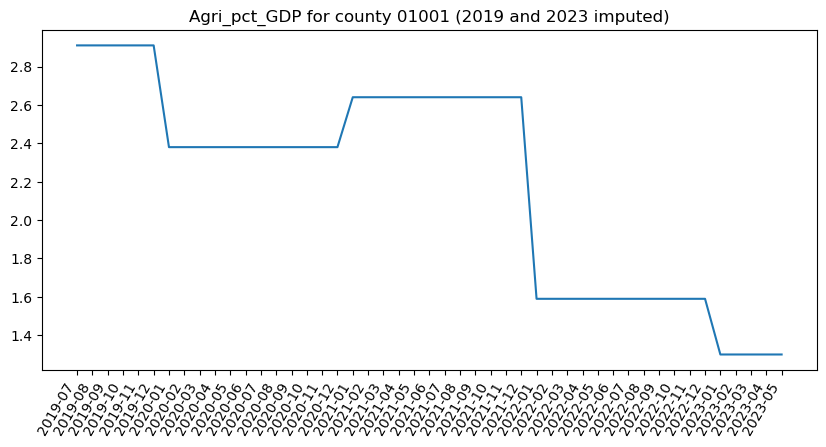

In [49]:
# see for county 01001
slice = block_2019_2023[:, 0, 0]
# plot for county 01001
plt.figure(figsize=(10, 5))
plt.plot(dates, slice)
plt.gcf().autofmt_xdate(rotation=60)
plt.title('Agri_pct_GDP for county 01001 (2019 and 2023 imputed)')
plt.show()

In [50]:
data_description = {}
for i in range(12):
    feature = features_list[i]
    feature_name = 'Prev_Yr_' + feature + '_Pct_GDP'
    data_description[f'feature_{i}'] = feature_name

data_description

{'feature_0': 'Prev_Yr_Agri_Pct_GDP',
 'feature_1': 'Prev_Yr_Mine_Pct_GDP',
 'feature_2': 'Prev_Yr_Retl_Pct_GDP',
 'feature_3': 'Prev_Yr_Manu_Pct_GDP',
 'feature_4': 'Prev_Yr_Info_Pct_GDP',
 'feature_5': 'Prev_Yr_FinS_Pct_GDP',
 'feature_6': 'Prev_Yr_EduS_Pct_GDP',
 'feature_7': 'Prev_Yr_EntS_Pct_GDP',
 'feature_8': 'Prev_Yr_Gvmt_Pct_GDP',
 'feature_9': 'Prev_Yr_GoMn_Pct_GDP',
 'feature_10': 'Prev_Yr_GoTr_Pct_GDP',
 'feature_11': 'Prev_Yr_GoMf_Pct_GDP'}

In [51]:
data_name = 'PrevYr_sectorGDP'

# save the block_2019_2023 to pickle file
with open(f'BLOCKED_{data_name}_data.pkl', 'wb') as f:
    pickle.dump(block_2019_2023, f)

# save the data description in json format
with open(f'BLOCKED_{data_name}_data_description.json', 'w') as f:
    json.dump(data_description, f)